In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore

import nibabel as nib
from nilearn.glm.first_level import glover_hrf
from nilearn.plotting import plot_anat, plot_epi, plot_glass_brain, plot_roi
from nilearn.image import mean_img, resample_img
from nilearn.signal import clean

main_path = "/jukebox/PNI-classes/students/NEU502/2023-NEU502B/wlong/multilang/"

In [2]:
data_path = os.path.join(main_path, "data/bids/")

func_path = os.path.join(data_path, 'sub-002/ses-01/func/sub-002_ses-01_task-language_bold.nii.gz')
anat_path = os.path.join(data_path, 'sub-002/ses-01/anat/sub-002_ses-01_T1w.nii.gz')

func_nib = nib.load(func_path)
func_data = func_nib.get_fdata()
anat_img = nib.load(anat_path).get_fdata().astype(bool)

tr = 1.5
n_trs = 630

## Mask

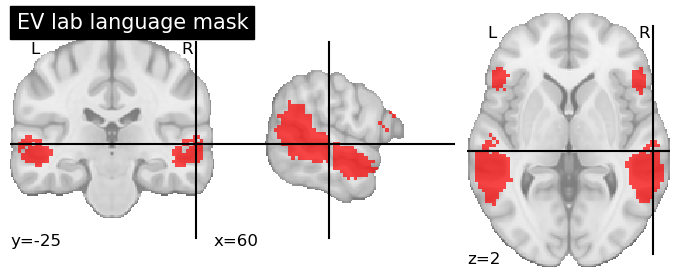

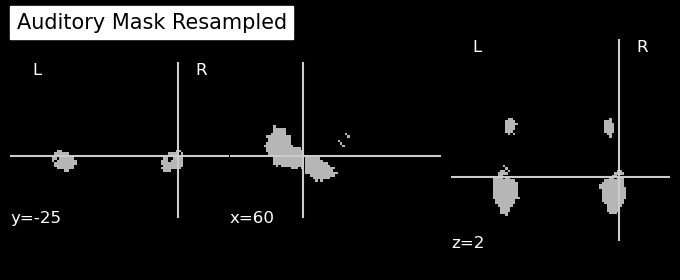

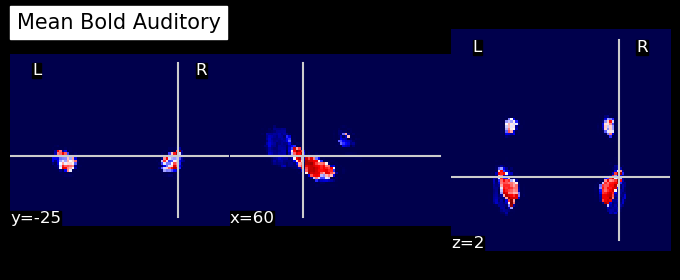

In [3]:
## Mask recommended by Sam - Language parcels
## https://evlab.mit.edu/funcloc/

func_img = nib.load(func_path) # load for affine

masker_path = 'allParcels_language_SN220.nii.gz'
cut_coords = (60, -25, 2)
lang_evlab_mask = nib.load(os.path.join(main_path, "masks", masker_path))
lang_evlab_data = lang_evlab_mask.get_fdata()

lang_bool_mask = nib.Nifti1Image(np.where(lang_evlab_data >= 1, 1., 0), 
                                 affine=lang_evlab_mask.affine)

masker = resample_img(lang_bool_mask, func_img.affine, 
                      target_shape=func_data.shape[:3], 
                      interpolation='nearest')

mask_aud = func_data.transpose(3, 0, 1, 2) * masker.get_fdata()  #using the apply mask function wasn't working at first
mask_aud = nib.Nifti1Image(mask_aud.transpose(1, 2, 3, 0), affine=func_img.affine)

plot_roi(masker, cut_coords=cut_coords, cmap='bwr_r', 
         title='EV lab language mask');
plot_anat(masker, cut_coords=cut_coords, title='Auditory Mask Resampled');
plot_epi(mean_img(mask_aud), cut_coords=cut_coords, cmap='seismic', title='Mean Bold Auditory');

## Confounders

In [4]:
high_pass = 1/128

# get n_times x n_voxels array of fmri signal within auditory cortex over time
bold_masked = func_data[masker.get_fdata().astype(bool)].T

# Re-run confound regression with high-pass filter
bold_clean = clean(bold_masked, 
                   detrend=True,
                   high_pass=high_pass, 
                   standardize='zscore',  ## PSC is used in notebook, but much higher value than expected
                   t_r=tr)

print('masked data shape:', bold_clean.shape)

Y = bold_clean[:n_trs]

# Assemble all regressors
confounds_dict = np.load(os.path.join(main_path, "preprocessed_data/confounds.npy"), allow_pickle=True).item()
confounds = confounds_dict['confounds']
confound_labels = confounds_dict['confound_labels']

masked data shape: (630, 6940)


## Stimulus

In [5]:
from util import language_glm_stim

familiar = ['English', 'Japanese']
unfamiliar = ['Icelandic', 'Spanish', 'Arabic', 'Chinese']

# load stimulus data
stim_df = pd.read_csv(os.path.join(main_path, 'stimulus_record/780929_502b_project_code_edited_2023-04-05_13h44.30.136.csv'))
t_scan_start = stim_df['key_resp.started'][0] + stim_df['key_resp.rt'][0]
stim_df.Language = stim_df.Language.str.split('_', expand=True).to_numpy()
stim_df.stimFile = stim_df.stimFile.str.split('/|_', expand=True).to_numpy()
stim_df.StimFile = stim_df.StimFile.str.split('/|_', expand=True).to_numpy()
stim_df['word'] = stim_df.stimFile

stim_df.loc[stim_df.word.isnull(), 'word'] = stim_df.loc[stim_df.word.isnull(), 'StimFile']
stim_df = stim_df[~stim_df.word.isnull()].reset_index(drop=True)


## Detecting start and end time
stim_start = stim_df['Sound.started'].to_numpy() - t_scan_start
block_start_indices = np.where(np.diff(stim_start) > 5.5)[0]
## Total switches: (3 session * 6 languages) - 1 = 17
assert len(block_start_indices) == 17 

block_end_time = stim_start[block_start_indices]
iti_interval = stim_start[block_start_indices + 1] - stim_start[block_start_indices]
block_start_time = (block_end_time + iti_interval)[:-1]
## Insert first stim start at the beginning
block_start_time = np.insert(block_start_time, 0, stim_start[0])
duration = block_end_time - block_start_time

# hrf
hrf = glover_hrf(tr, time_length = 45, oversampling = 1)

l1_stim_conv, l2_stim_conv = language_glm_stim(stim_df, familiar, unfamiliar, tr, 
                                               n_trs, hrf, block_start_time, 
                                               block_end_time)


array(['Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese',
       'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese',
       'Icelandic', 'Icelandic', 'Icelandic', 'Icelandic', 'Icelandic',
       'Icelandic', 'Icelandic', 'Icelandic', 'Icelandic', 'Icelandic',
       'English', 'English', 'English', 'English', 'English', 'English',
       'English', 'English', 'English', 'English', 'Spanish', 'Spanish',
       'Spanish', 'Spanish', 'Spanish', 'Spanish', 'Spanish', 'Spanish',
       'Spanish', 'Spanish', 'Arabic', 'Arabic', 'Arabic', 'Arabic',
       'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic',
       'Chinese', 'Chinese', 'Chinese', 'Chinese', 'Chinese', 'Chinese',
       'Chinese', 'Chinese', 'Chinese', 'Chinese', 'Icelandic',
       'Icelandic', 'Icelandic', 'Icelandic', 'Icelandic', 'Icelandic',
       'Icelandic', 'Icelandic', 'Icelandic', 'Icelandic', 'Spanish',
       'Spanish', 'Spanish', 'Spanish', 'Spanish', 'Spanish', 'Spanish',
       'Spanish

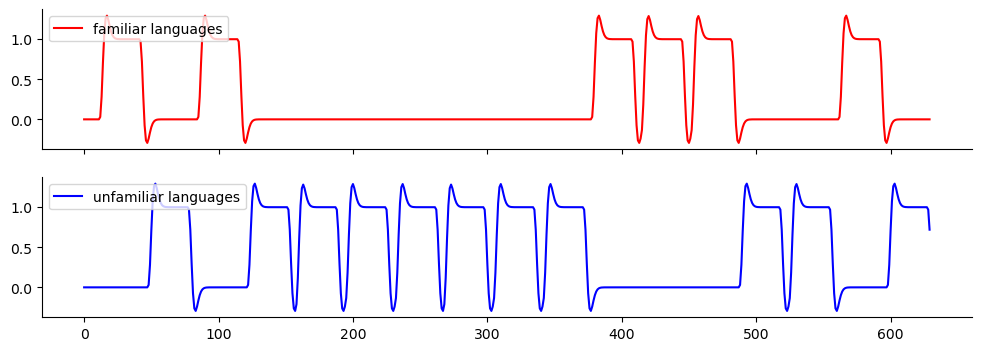

In [6]:
fig, axs = plt.subplots(2, 1, figsize = (12, 4), sharex = True, sharey = True)

axs[0].plot(l1_stim_conv, c = "red", label = 'familiar languages')
axs[1].plot(l2_stim_conv, c = "blue", label = 'unfamiliar languages')

axs[0].legend(loc = "upper left")
axs[1].legend(loc = "upper left")

sns.despine()

stim_df['Language'].values

In [7]:
from util import make_onset_dur_event_df

familiar_df = make_onset_dur_event_df(stim_df, familiar, unfamiliar, 
                                       block_start_time, duration)
familiar_df

,onset,duration,trial_type
0,15.064505,44.962951,familiar
1,70.058242,44.978399,unfamiliar
2,125.068851,44.961551,familiar
3,180.062581,44.961759,unfamiliar
4,235.023018,45.011608,unfamiliar
5,290.033193,44.995442,unfamiliar
6,345.060559,44.961684,unfamiliar
7,400.037731,44.994798,unfamiliar
8,455.031570,44.995197,unfamiliar
9,510.025558,44.995145,unfamiliar


## GLM

In [8]:
from pandas import DataFrame
from nilearn.glm.first_level import FirstLevelModel

block_dict = np.load(os.path.join(main_path, "preprocessed_data/block_time.npy"), allow_pickle=True).item()
block_start_time = block_dict['start']
duration = block_dict['duration']

confounds_df = DataFrame({l: c for l, c in zip(confound_labels, confounds.T)
                          if l != 'intercept'})

# Intialize Nilearn's GLM
glm = FirstLevelModel(t_r=tr,
                      mask_img=masker,
                      noise_model='ar1',
                      standardize=True,
                      hrf_model='glover',
                      drift_model='cosine',
                      high_pass=1/128)

# Fit the GLM to BOLD data
glm.fit(func_nib, 
        events=familiar_df, 
        confounds=confounds_df)

FirstLevelModel(high_pass=0.0078125,
                mask_img=<nibabel.nifti1.Nifti1Image object at 0x7fa20bddcc40>,
                t_r=1.5)

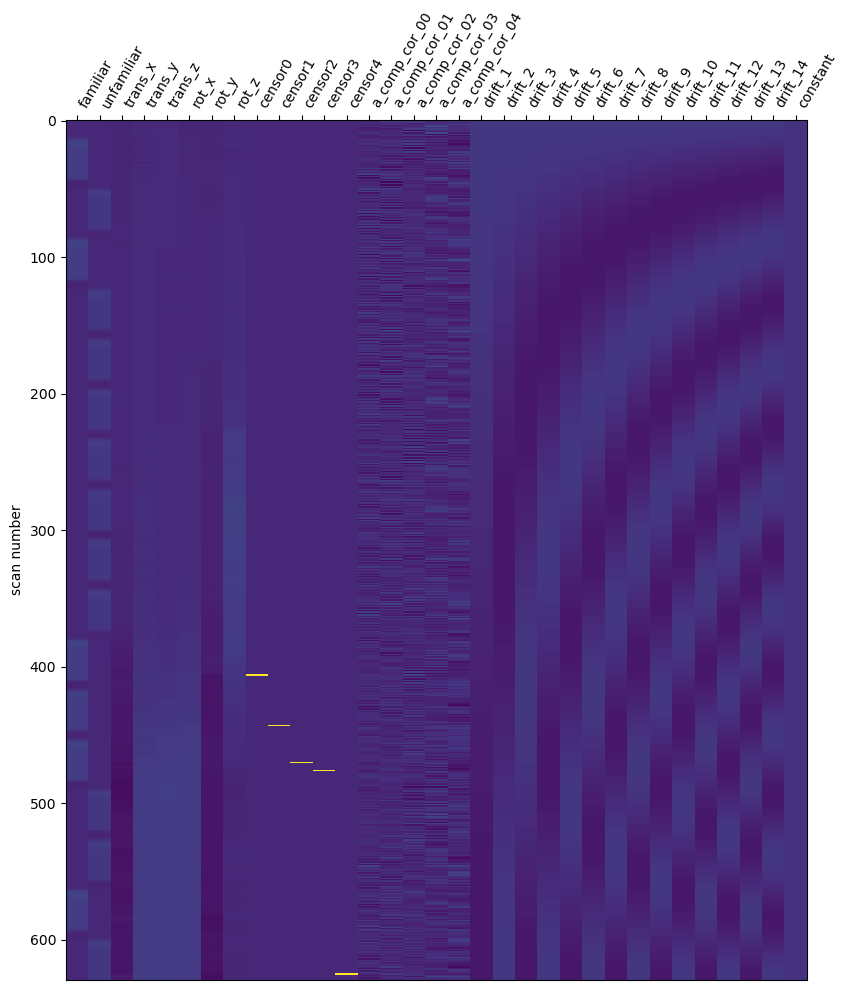

In [9]:
# Extract Nilearn's design matrix and plot it
from nilearn.plotting import plot_design_matrix

design_matrix = glm.design_matrices_[0]
plot_design_matrix(design_matrix)
plt.show()

In [10]:
contrast = np.zeros(len(glm.design_matrices_[0].columns))
contrast[0] = 1
contrast[1] = -1

# Extract betas for contrast
beta_map = glm.compute_contrast(contrast,
               output_type='effect_size').get_fdata()
beta_map[beta_map == 0] = np.nan

/usr/people/iwahle/miniconda3/envs/neu502b/lib/python3.10/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


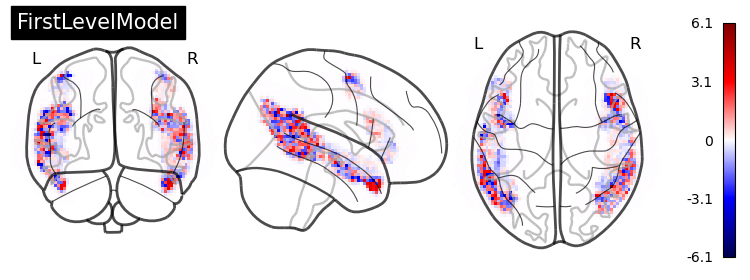

In [11]:
beta_img = nib.Nifti1Image(beta_map, affine=masker.affine)

plot_glass_brain(beta_img, colorbar=True, cmap='seismic', 
                 plot_abs=False, title='FirstLevelModel');